## Backtranslating glosses 
The backtranslation results indicate that there are gains to be had from parsing glosses instead of parsing inputs. However, parsing + glossing + parsing requires 3x the computation, so it should only be done at low confidence. This notebook is for exploring whether that's a feasible strategy. 

In [32]:
import json 
from collections import defaultdict
import re 

import numpy as np 
from dataflow.core.lispress import render_compact, parse_lispress

gold_tgt_file = "/brtx/601-nvme1/estengel/resources/data/smcalflow.agent.data.from_benchclamp/dev_all.tgt"
gold_src_file = "/brtx/601-nvme1/estengel/resources/data/smcalflow.agent.data.from_benchclamp/dev_all.src_tok"

pred_from_gloss_file = "/brtx/604-nvme1/estengel/calflow_calibration/benchclamp/lispress_to_text_context/1.0/bart-large_calflow_last_user_all_0.0001/checkpoint-10000/for_roundtrip/predicted_dev_all.tgt"
pred_from_input_file = "/brtx/604-nvme1/estengel/calflow_calibration/miso/tune_roberta_tok_fix_benchclamp_data/translate_output_calibrated/dev_all.tgt" 


def read_gold_file(file):
    with open(file) as f:
        if file.endswith(".tgt"):
            to_ret = [render_compact(parse_lispress(line)) for line in f.readlines()]
        else:
            to_ret = [re.sub("__StartOfProgram", "", x).strip() for x in f.readlines()]
    return to_ret 

def read_nucleus_file(miso_pred_file, return_dict=True, n_preds = 3):
    with open(miso_pred_file, "r") as f:
        data = [json.loads(x) for x in f.readlines()]
    to_ret = []
    if return_dict:
        data_by_src_str = defaultdict(list)
        for line in data:
            data_by_src_str[line['src_str']].append(line) 
        to_iterate = data_by_src_str.items()
    else:
        # chunk data into groups of n_preds
        to_iterate = [data[i:i + n_preds] for i in range(0, len(data), n_preds)]
    # for src_str, lines in data_by_src_str.items():
    for item in to_iterate:
        if return_dict:
            src_str, lines = item
        else:
            lines = item
        total_probs = [np.exp(np.sum(np.log(x['expression_probs']))) 
                                if x['expression_probs'] is not None else 0.0 
                                    for x in lines ]
        min_probs = []
        for x in lines:
            if x['expression_probs'] is not None and len(x['expression_probs']) > 0:
                min_probs.append(np.min(x['expression_probs']))
            else:
                min_probs.append(0.0)

        combo_lines = zip(lines, min_probs, total_probs)
        sorted_combo_lines = sorted(combo_lines, key=lambda x: x[-1], reverse=True)
        if return_dict:
            data_by_src_str[src_str] = sorted_combo_lines
        to_ret.append(sorted_combo_lines)
    if return_dict: 
        return data_by_src_str
    return to_ret 


## First, get predicted lispress from nucleus file 

In [33]:
pred_from_input = read_nucleus_file(pred_from_input_file, return_dict=False)
top_nuc_preds = []
for lines in pred_from_input:
    nuc_data = lines[0][0]
    try:
        pred_tgt = render_compact(parse_lispress(nuc_data['tgt_str']))
    except: 
        pred_tgt = "(ERROR)"
    top_nuc_preds.append(pred_tgt)

print(len(top_nuc_preds))
with open("/brtx/604-nvme1/estengel/calflow_calibration/miso/tune_roberta_tok_fix_benchclamp_data/translate_output_calibrated/dev_all_just_tgt.tgt", "w") as f1:
    for line in top_nuc_preds:
        f1.write(line + "\n")

12271


## Backtranslate tgt file 

In [ ]:
!python hit/scripts/prep_for_translate.py --miso_pred_file /brtx/604-nvme1/estengel/calflow_calibration/miso/tune_roberta_tok_fix_benchclamp_data/translate_output_calibrated/dev_all.tgt --src_file /brtx/601-nvme1/estengel/resources/data/smcalflow.agent.data.from_benchclamp/dev_all.src_tok --tgt_file /brtx/601-nvme1/estengel/resources/data/smcalflow.agent.data.from_benchclamp/dev_all.tgt --n_pred 3 --out_file /brtx/604-nvme1/estengel/calflow_calibration/miso/tune_roberta_tok_fix_benchclamp_data/translate_output_calibrated/dev_all_for_backtranslate.jsonl

In [34]:
!./calibration_scripts/translate_miso_output.sh \
    /brtx/604-nvme1/estengel/calflow_calibration/benchclamp/lispress_to_text_context/1.0/bart-large_calflow_last_user_all_0.0001/checkpoint-10000 \
    /brtx/604-nvme1/estengel/calflow_calibration/miso/tune_roberta_tok_fix_benchclamp_data/translate_output_calibrated/dev_all_for_backtranslate.jsonl \
    /brtx/604-nvme1/estengel/calflow_calibration/benchclamp/lispress_to_text_context/1.0/bart-large_calflow_last_user_all_0.0001/checkpoint-10000/outputs_from_nucleus_backtranslate
    

/bin/bash: ./calibration_scripts/translate_miso_output.sh: No such file or directory


In [2]:
gold_tgt_data = read_gold_file(gold_tgt_file)
gold_src_data = read_gold_file(gold_src_file)
pred_from_gloss = read_gold_file(pred_from_gloss_file)
# do need to re-run parsing, since currently rephrasing is not based on nucleus decoding 
pred_from_input = read_nucleus_file(pred_from_input_file)

src_to_gloss_lut = {src: gloss for src, gloss in zip(gold_src_data, pred_from_gloss)}
src_to_tgt_lut = {src: tgt for src, tgt in zip(gold_src_data, gold_tgt_data)}
# src_to_pred_lut = {src: tgt for src, tgt in zip(gold_src_data, pred_from_input)}

In [8]:
bin_data = []
for src in pred_from_input.keys():
    tgt_from_gloss = src_to_gloss_lut[src]
    gold_tgt = src_to_tgt_lut[src]
    nuc_data = pred_from_input[src][0][0]

    try:
        tgt_from_input = render_compact(parse_lispress(nuc_data['tgt_str']))
    except:
        tgt_from_input = "(Error)"

    expr_probs = nuc_data['expression_probs']
    if expr_probs is None or len(expr_probs) == 0:
        continue
    min_prob = np.min(expr_probs)

    literal_correct = tgt_from_input == gold_tgt
    gloss_correct = tgt_from_gloss == gold_tgt
    bin_data.append({"gloss_correct": gloss_correct, "literal_correct": literal_correct, "min_prob": min_prob})
    # plot_data.append({"correct": literal_correct,
    #                   "type": "literal",
    #                   "min_prob": min_prob})

    # plot_data.append({"correct": gloss_correct,
    #                   "type": "gloss",
    #                   "min_prob": min_prob})


In [18]:
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats 

bin_df = pd.DataFrame(bin_data)

data_to_plot = []
n_bins = 10

(gloss_values, 
gloss_bins, 
bin_number) = stats.binned_statistic(
    bin_df['min_prob'], 
    bin_df['gloss_correct'], 
    statistic='mean', 
    bins=n_bins)

gloss_bins_to_plot = []
for i in range(len(gloss_bins)-1): 
    bin_median = np.round((gloss_bins[i] + gloss_bins[i+1])/2.0,2)
    data_to_plot.append({"acc": gloss_values[i], "bin": bin_median, "type": "gloss"})

(literal_values, 
literal_bins, 
bin_number) = stats.binned_statistic(
    bin_df['min_prob'], 
    bin_df['literal_correct'], 
    statistic='mean', 
    bins=n_bins)

literal_bins_to_plot = []
for i in range(len(literal_bins)-1): 
    bin_median = np.round((literal_bins[i] + literal_bins[i+1])/2.0,2)
    data_to_plot.append({"acc": literal_values[i], "bin": bin_median, "type": "literal"})

Text(0.5, 0, 'Min. Expression Probability')

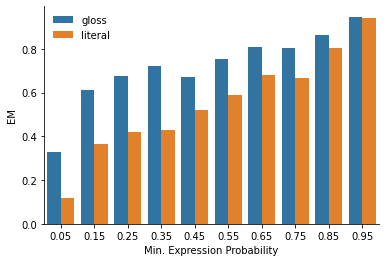

In [22]:

df_to_plot = pd.DataFrame(data_to_plot)
fix, ax = plt.subplots(1,1)
sns.barplot(data=df_to_plot, x="bin", y="acc", hue="type", ax=ax )
sns.despine()
ax.legend(frameon=False)
ax.set_ylabel("EM")
ax.set_xlabel("Min. Expression Probability")